In [28]:
pip install tensorflow keras pandas matplotlib scikit-learn opencv-python


In [10]:
import os
import shutil
import pandas as pd

# Load CSV
csv_path = r'C:\Users\ramil\jangoFinalWeb\myproject\websiteApp\data\final.csv'
data = pd.read_csv(csv_path)

# Specify the directory where the new folder structure will be created
base_dir = r'C:\Users\ramil\jangoFinalWeb\myproject\dataset\images'

# Create class subdirectories
for label in data['label'].unique():
    label_dir = os.path.join(base_dir, label)
    if not os.path.exists(label_dir):
        os.makedirs(label_dir)

# Move images into their respective class directories
for _, row in data.iterrows():
    image_path = row['image_path']
    label = row['label']
    # Copy the image to the corresponding class folder
    shutil.copy(image_path, os.path.join(base_dir, label))


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Image size and batch size
img_size = (224, 224)  # Adjust according to your model requirements
batch_size = 32

# Create a data generator with augmentation and rescaling
datagen = ImageDataGenerator(
    rescale=1.0 / 255,     # Normalize pixel values to [0, 1]
    validation_split=0.2    # 20% for validation
)

# Train Data
train_data = datagen.flow_from_dataframe(
    dataframe=data,
    x_col="image_path",        # Image path column
    y_col="label",             # Label column
    target_size=img_size,      # Resize images
    batch_size=batch_size,
    class_mode="categorical",  # Multi-class classification
    subset="training",         # Use 80% of data for training
    shuffle=True               # Shuffle the data
)

# Validation Data
val_data = datagen.flow_from_dataframe(
    dataframe=data,
    x_col="image_path",
    y_col="label",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",  # Multi-class classification
    subset="validation",       # Use 20% of data for validation
    shuffle=True
)

# Verify the data generators
print(f"Training samples: {train_data.samples}")
print(f"Validation samples: {val_data.samples}")


Found 3977 validated image filenames belonging to 40 classes.
Found 994 validated image filenames belonging to 40 classes.
Training samples: 3977
Validation samples: 994


In [14]:
from tensorflow.keras import layers, models

# Get the number of classes from train_data
num_classes = len(train_data.class_indices)

# Define the CNN model
model = models.Sequential([
    layers.InputLayer(input_shape=(224, 224, 3)),  # Input layer (224x224 RGB images)
    layers.Conv2D(32, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dense(num_classes, activation="softmax")  # Output layer with num_classes
])

# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [16]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        # You can also use 'val_accuracy'
    patience=5,                # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore the best model weights
)

# Define ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    'checkpoint.keras',           # File where the best model will be saved during training
    monitor='val_loss',        # Monitor validation loss (can also use 'val_accuracy')
    save_best_only=True,       # Save the best model only
    mode='min',                # Minimize the loss
    verbose=1
)

# Train the model with the callbacks
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,  # Start with a higher number of epochs, early stopping will limit it
    callbacks=[early_stopping, model_checkpoint]
)

# Save the final model after training is complete (even if early stopping was used)
model.save(r'C:\Users\ramil\OneDrive\Desktop\djangoremake\WebsiteProject\App\models\web.keras')
print("Final model saved as 'web.keras'")


c:\Users\ramil\jangoFinalWeb\env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.1962 - loss: 3.1785
Epoch 1: val_loss improved from inf to 14.86325, saving model to checkpoint.keras
125/125 ━━━━━━━━━━━━━━━━━━━━ 760s 6s/step - accuracy: 0.1977 - loss: 3.1715 - val_accuracy: 0.0010 - val_loss: 14.8633
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.7501 - loss: 0.8699
Epoch 2: val_loss did not improve from 14.86325
125/125 ━━━━━━━━━━━━━━━━━━━━ 718s 6s/step - accuracy: 0.7503 - loss: 0.8692 - val_accuracy: 0.0060 - val_loss: 21.5048
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8746 - loss: 0.4151
Epoch 3: val_loss did not improve from 14.86325
125/125 ━━━━━━━━━━━━━━━━━━━━ 812s 6s/step - accuracy: 0.8747 - loss: 0.4148 - val_accuracy: 0.0091 - val_loss: 29.7777
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9329 - loss: 0.2048
Epoch 4: val_loss did not improve from 14.86325
125/125 ━━━━━━━━━━━━━━━━━━━━ 786s 6s/step - accuracy: 0.9329 - loss: 0.2048 -

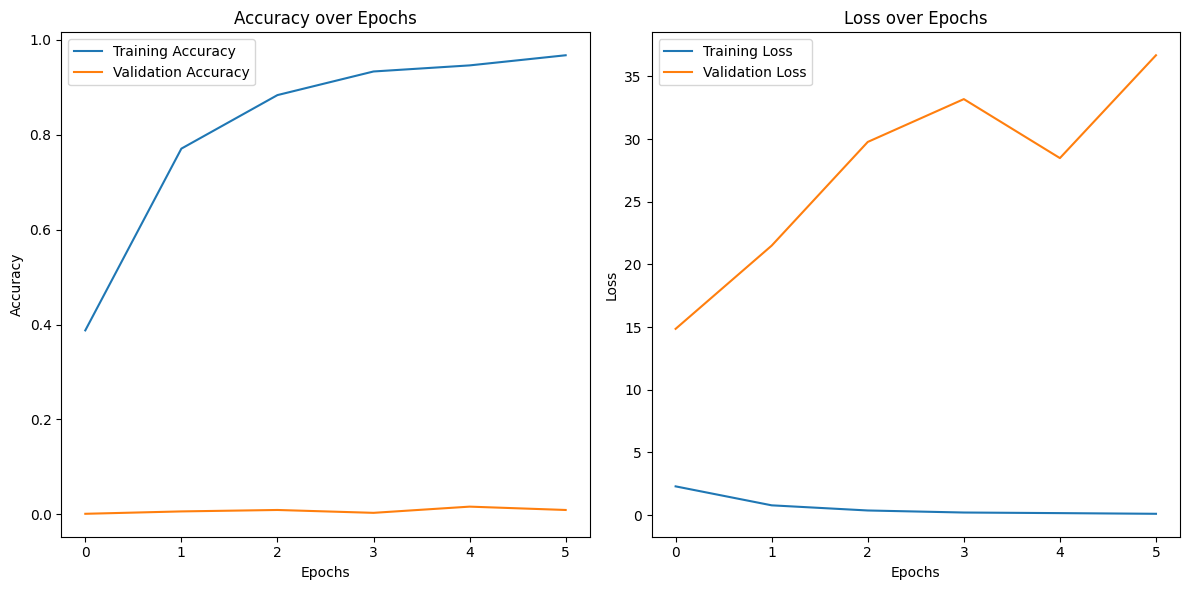

In [17]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
history_dict = history.history
acc = history_dict['accuracy']  # Training accuracy
val_acc = history_dict['val_accuracy']  # Validation accuracy
loss = history_dict['loss']  # Training loss
val_loss = history_dict['val_loss']  # Validation loss

# Plot Accuracy over Epochs
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss over Epochs
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [19]:
import pandas as pd

# Load the CSV file
csv_path = r'C:\Users\ramil\OneDrive\Desktop\djangoremake\WebsiteProject\App\data\final.csv'  # Path to your CSV file
data = pd.read_csv(csv_path)

# Get the unique class labels from the 'label' column
class_names = sorted(data['label'].unique())  # Sorted to ensure consistent ordering

print("Class Names:", class_names)


Class Names: ['Adelfa', 'Akapulko', 'Ampalaya', 'Averrhoea bilimbi', 'Banaba', 'Bayabas', 'Bignay', 'Calamansi', 'Dalandan', 'Dayap', 'Gliricidia sepium', 'Gumamela', 'Guyabano', 'Hierba Buena', 'Impatiens balsamina', 'Ipil-ipil', 'Kamote', 'Kamoteng Kahoy', 'Lagundi', 'Luyang Dilaw', 'Luyos', 'Malunggay', 'Mangga', 'Mani', 'Mayana', 'Oregano', 'Pandan', 'Pepromia pellucida', 'Premna odorata', 'Sabila', 'Saluyot', 'Sambong', 'Sampa-sampalukan', 'Sampalok', 'Siling Labuyo', 'Suha', 'Takip-kuhol', 'Tawa-tawa', 'Tsaang Gubat', 'Tuba-tuba']


In [21]:
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

# Load the model
model = load_model(r'C:\Users\ramil\OneDrive\Desktop\djangoremake\WebsiteProject\App\models\web.keras')

# Load the CSV file
csv_path = r'C:\Users\ramil\OneDrive\Desktop\djangoremake\WebsiteProject\App\data\final.csv'  # Path to your CSV file
data = pd.read_csv(csv_path)

# Class labels (replace with your actual class labels)
class_names = ['Adelfa', 'Akapulko', 'Ampalaya', 'Averrhoea bilimbi', 'Banaba', 'Bayabas', 'Bignay', 'Calamansi', 'Dalandan', 'Dayap', 'Gliricidia sepium', 'Gumamela', 'Guyabano', 'Hierba Buena', 'Impatiens balsamina', 'Ipil-ipil', 'Kamote', 'Kamoteng Kahoy', 'Lagundi', 'Luyang Dilaw', 'Luyos', 'Malunggay', 'Mangga', 'Mani', 'Mayana', 'Oregano', 'Pandan', 'Pepromia pellucida', 'Premna odorata', 'Sabila', 'Saluyot', 'Sambong', 'Sampa-sampalukan', 'Sampalok', 'Siling Labuyo', 'Suha', 'Takip-kuhol', 'Tawa-tawa', 'Tsaang Gubat', 'Tuba-tuba']

# Function to preprocess the image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)  # Load and resize the image
    img_array = img_to_array(img) / 255.0  # Normalize the image
    return np.expand_dims(img_array, axis=0)  # Expand dimensions for model input

# Initialize results list
results = []

# Loop through each image in the CSV
for _, row in data.iterrows():
    image_path = row['image_path']
    true_label = row['label']
    definition = row['definition']
    
    # Preprocess the image
    input_image = preprocess_image(image_path)
    
    # Predict the label
    predictions = model.predict(input_image)
    predicted_class_idx = np.argmax(predictions, axis=1)[0]
    predicted_label = class_names[predicted_class_idx]
    confidence = np.max(predictions) * 100
    
    # Append the results
    results.append({
        'image_path': image_path,
        'true_label': true_label,
        'predicted_label': predicted_label,
        'confidence': f"{confidence:.2f}%",
        'definition': definition
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Save the results to a CSV
results_df.to_csv(r'C:\Users\ramil\jangoFinalWeb\myproject\websiteApp\datapredictions_output.csv', index=False)
print("Predictions saved to 'predictions_output.csv'")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━

In [5]:
from tensorflow.keras.models import load_model
model = load_model(r'C:\Users\ramil\OneDrive\Desktop\djangoremake\WebsiteProject\App\models\web.keras')


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import os

# 1. Load the trained model
model_path = r'C:\Users\ramil\OneDrive\Desktop\djangoremake\WebsiteProject\App\models\web.keras'
model = load_model(model_path)

# 2. Load the CSV file containing image paths and labels
csv_path = r'C:\Users\ramil\jangoFinalWeb\myproject\websiteApp\data\final.csv'
data = pd.read_csv(csv_path)

# 3. Preprocess images
def preprocess_image(img_path, target_size=(224, 224)):
    """Load and preprocess a single image."""
    img = image.load_img(img_path, target_size=target_size)  # Resize image
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0, 1]
    return img_array

# 4. Load all images and labels
X_test = []
y_true = []

for idx, row in data.iterrows():
    img_path = row['image_path']
    label = row['label']
    
    # Ensure the image path is valid
    full_img_path = os.path.join("data", img_path)  # Adjust path as needed
    if os.path.exists(full_img_path):
        img_array = preprocess_image(full_img_path)
        X_test.append(img_array)
        y_true.append(label)
    else:
        print(f"Image not found: {full_img_path}")

# Convert to numpy arrays
X_test = np.array(X_test)
y_true = np.array(y_true)

# 5. Predict probabilities
y_pred_probs = model.predict(X_test)

# Flatten the predictions if needed (for binary classification)
if y_pred_probs.shape[1] == 1:
    y_pred_probs = y_pred_probs.flatten()

# 6. Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

# Calculate AUC (Area Under the Curve)
roc_auc = roc_auc_score(y_true, y_pred_probs)

# 7. Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()


MemoryError: Unable to allocate 2.79 GiB for an array with shape (4971, 224, 224, 3) and data type float32

In [9]:
print(model.input_shape)


(None, 224, 224, 3)
